### I am going to implement `micrograd` from Karpathy's famous YouTube video:

## Link: https://www.youtube.com/watch?v=VMj-3S1tku0


How this notebook is divided:

1. Intuition about derivatives
2. Building out the Value class and adding visualisation capability
3. Manually back-prop through `L = ((a*b) + c) + f`
4. Manually back-prop through a Neuron
5. Make the Value Class more robust
6. Implement tanh with basic operations i.e. (e^2x-1)/(e^2x+1)
7. Implement `Neuron`, `Layer` and `MLP`
8. Implement the loss function (MSE)
9. Wrap it up into a forward pass, backward pass and update sort of structure
10. Wrap it up in a loop with `zero_grad()`



- It's an Autograd (automatic gradient) Engine.
- Implements Backpropagation.
- Backpropagation allows you to efficiently evaluate the gradient of a loss function with respect to the weights of a NN.
- We can iteratively tune the weights of the NN to minimize the loss function and improve the accuracy of the network.

- It is at the core of PyTorch / JAX



We wrap the scaler values around a `Value` object.

In [1]:
import numpy as np


```
from micrograd.engine import Value

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass

g.backward() # will initialise backprop @ the node g.

print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db
```

---


`Value` will wrap the numbers. 

- add
- multiply
- raise to a power
- offset by one
- negate
- squash at zero (relu)
- square
- divide by constant
- divide by it


It will build out the entire mathematical graph and it will know where `g` came from.

Backprop will go backwards through the expression graph and apply chain rule recursively.

We can query `dg/da` --> `a.grad` (`138.8338`)  

The derivative `dg/da` or `dg/db` is important information as it tells how `a` and `b` affect `g` through the mathematical expression/graph. So, if `a.grad` is `138`, when we slightly nudge `a` in the positive direction (making it slightly larger), `a.grad = 138` tells us that `g` will grow and the slope of that growth will be `138`.

NNs are just **mathematical expressions**. The expression in the example is meaningless. We care about NN.

Backprop is actualy much more general. It cares about arbitrary mathematical expressions. We happen to use it though in NNs as an application.


Tensors and arrays are primarily used for efficiency purposes. The underlying mathematics remains unchanged when transitioning from scalars to tensors. Therefore, implementing tensors from scratch offers little benefit.

1. Engine: 100 lines of Code
2. nn.py : A joke, we define a Neuron, a Layer of Neurons and a MLP which is a sequence of Layers.



**Claim**: Micrograd is all you need to train NNs. Everything else is just efficiency.

# What is a Derivitve (intuition)

In [2]:
# imports:

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


$f(x) = 3x^2 - 4x + 5$

In [3]:
def f(x):
    return 3*x**2 - 4*x +5


In [4]:
f(3.0)


20.0

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


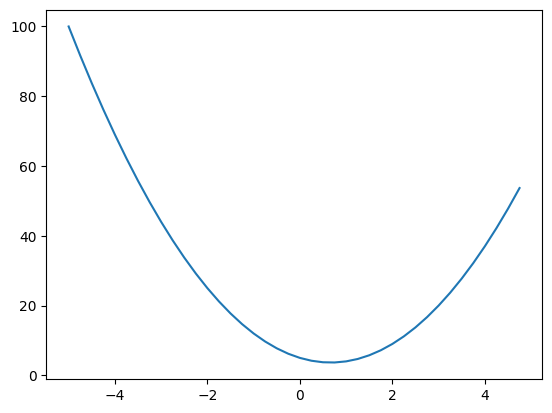

In [5]:
# plot to get a sense of it's shape

xs = np.arange(-5, 5, 0.25)
print(xs)
ys = f(xs)

plt.plot(xs, ys)


No one does the derivative mathematically or symbolically. The expression for the NN is just too large for one to try an analytical / symbolic approach. 


Let's understand the definition of the derivative and what it actually tells you about the function.

Definition according to Wikipedia:

$L = \lim_{h \to 0} \frac{f(a + h) - f(a)}{h}$


If you slightly increase the x by a small number h, with what sensitivity does the function respond? What is the slope at that point? Does it go up or does it go down? It's the slope of that response at that time

In [6]:
print(f(3.0))

h = 0.000000000001
print(f(3.0 + h))


20.0
20.000000000014


We expect `f(3.0 + h)` > `f(3.0)` as according to the graph the function is rising at `f(3.0)`, so if we bump up the value by a small amount `h`, then the function should also give out a value that's larger than `f(3.0)`.


In [7]:
h = 0.000000000001
x = 3.0

# slope - >
( f(x+h) - f(x) ) / h


14.001244608152774

Also verify it analytically:

$f(x) = 3x^2 - 4x + 5$

$f'(x) = 6x - 4$

So, $f'(3) = 18 - 4 = 14$


In [8]:
h = 0.000000000001
x = -3.0


# the sign of the slope will be negative, because as per the graph, if we bump x and go a bit in the positive direction then the function will decrease, so the slope will be negative.

# slope - >
( f(x+h) - f(x) ) / h


-21.9984030991327

In [9]:
h = 0.000000000001
x = 2/3

# slope - >
( f(x+h) - f(x) ) / h


-0.0004440892098500626

Derivitive becomes zero. At 2/3 the function does not respond when we nude the input by a tiny amount...


## Now let's make it a bit more complex (still derivative intuition)

In [10]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)


4.0


## Let's get the derivitive of `d` wrt to `a`, `b` and `c`


### Bumping a

In [11]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

# -----
a += h
# -----

d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('Slope: ', (d2 - d1)/h) # how much the function increased when we bumped the input we are interested in by 
                            # a tiny amount

# Slope = d1/da -> d1/da = b


d1:  4.0
d2:  3.999699999999999
Slope:  -3.000000000010772


### Bumping b

In [12]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# -----
b += h
# -----
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # how much the function increased when we bumped the input we are interested in by 
                            # a tiny amount

# So we need to check d1/db = a (a=2.0)


d1 4.0
d2 4.0002
slope 2.0000000000042206


### Bumping c

In [13]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# -----
c += h
# -----
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # how much the function increased when we bumped the input we are interested in by 
                            # a tiny amount

# dd1/dc = 1


d1 4.0
d2 4.0001
slope 0.9999999999976694


# Let's move to NN

## Let's build out the value object

In [14]:
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data)
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3)
c = Value(10.0)
# a+b ==> a.__add__(b)
# a*b ==> a.__mul__(b)

# a * b + c  -> (a.__mul__(b)).__add__(c)

# a * b + c
# (a.__mul__(b)).__add__(c)

d = a*b + c
print((a.__mul__(b)).__add__(c))
print(f"d: {d}")


Value(data=4.0)
d: Value(data=4.0)


We have to tell Python how to add two Value objects

Now we are missing the connective tissue of this expression. We want expression graphs, so we need to maintain pointers as to what values led to other values


In [15]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label # passed as input

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data,  (self, other), "*")
        return out


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')   


d = a*b + c; d.label = 'd'
print((a.__mul__(b)).__add__(c))
print(f"d: {d}")


Value(data=4.0)
d: Value(data=4.0)


### How to visualise the graph of operations?


In [16]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  print(f"nodes", nodes)
  print("================")
  print(f"edges", edges)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


nodes {Value(data=2.0), Value(data=10.0), Value(data=-6.0), Value(data=-3.0), Value(data=4.0)}
edges {(Value(data=-6.0), Value(data=4.0)), (Value(data=2.0), Value(data=-6.0)), (Value(data=-3.0), Value(data=-6.0)), (Value(data=10.0), Value(data=4.0))}


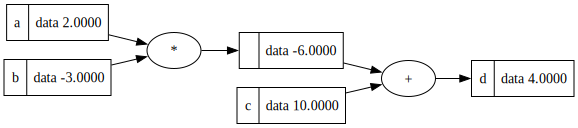

In [17]:
draw_dot(d)


In [18]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label # passed as input

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data,  (self, other), "*")
        return out


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')   

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')

L = d * f; L.label = 'L'
print(f"L: {L}")

print(f"\ne = a*b\t(a=2, b=-3)\ne._prev: {e._prev}, e._op: {e._op}")
print(f"\nd = e + c\t(e=-6, c=10)\nd._prev: {d._prev}, d._op: {d._op}")


L: Value(data=-8.0)

e = a*b	(a=2, b=-3)
e._prev: {Value(data=2.0), Value(data=-3.0)}, e._op: *

d = e + c	(e=-6, c=10)
d._prev: {Value(data=-6.0), Value(data=10.0)}, d._op: +


#### How to visualise

In [19]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


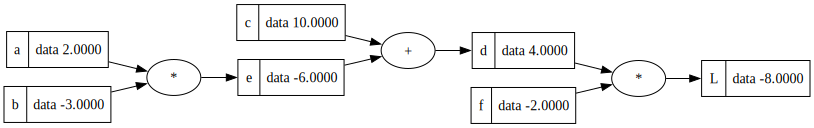

In [20]:
draw_dot(L)


So now we are interested in the derivative of the output with respect to some of it's leaf nodes. In a NN setting we will be very interested in the derivative of the loss of the NN with respect to the weights of the NN. It will tell us how the loss of the NN is being affected by the weights, so we can tweak the weights to get lesser loss.


So now we have to create a variable inside the value class that maintains the derivative of L wrt to that Value. We call this variable `grad`.


In [21]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data,  (self, other), "*")
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')   

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')

L = d * f; L.label = 'L'
print(f"The final value of L: {L.data}")

print(f"d._prev: {d._prev}, d._op: {d._op}")
print(f"e._prev: {e._prev}, e._op: {e._op}")


The final value of L: -8.0
d._prev: {Value(data=-6.0), Value(data=10.0)}, d._op: +
e._prev: {Value(data=2.0), Value(data=-3.0)}, e._op: *


In [22]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


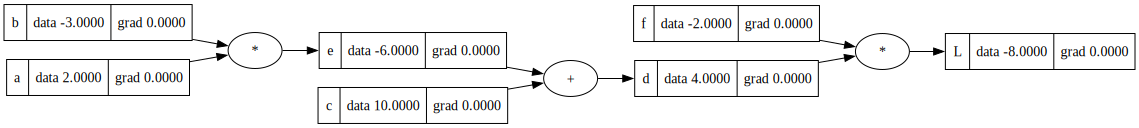

In [23]:
draw_dot(L)


## Now we are ready to fill in the gradients! We'll do backprop manually.

In [24]:
# find dL/dL

def verify_derivatives_numerically(): #done so that I don't mess up the global scope
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'

    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'

    L2 = L.data + h

    print((L2-L1)/h)

verify_derivatives_numerically()


1.000000000000334


So it's obvious that the gradient of `L` will be `1`.

Let's do backprop manually


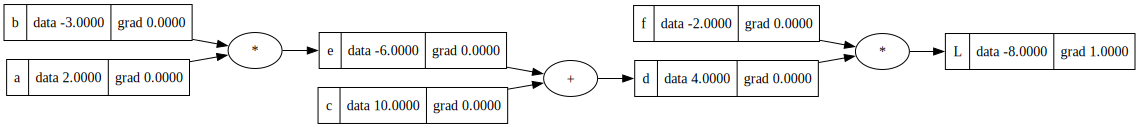

In [25]:
L.grad = 1.0

draw_dot(L)


Now let's figure out the grad of `d` now.

So now we need to figure out $\frac{dL}{dd}$ and we know $L = d*f$.


So, given,

$L = d * f$

To find: $\frac{dL}{dd}$.

---

And analytically (from calculus),

$\frac{dL}{dd} = f$



Now let's derive it:


$\frac{df}{dx} = \frac{f(x+h) - f(x)}{h}$

So, 
$\frac{dL}{dd} =  \frac{(d+h)*f - d*f}{h}$ => $ \frac{df + fh - df}{h}$ => $ \frac{fh}{h}$ ==> $f$


### Derivative of $L$ with respect to $d$

Given:  
$
L = d \cdot f
$

By basic calculus:
$
\frac{dL}{dd} = f
$

---

Now, let's derive it using the definition of a derivative:

$
\frac{dL}{dd} = \lim_{h \to 0} \frac{L(d + h) - L(d)}{h}
$

Substitute $L = d \cdot f$ (assuming $f$ is constant with respect to $d$):

$
= \lim_{h \to 0} \frac{(d + h) \cdot f - d \cdot f}{h}
$

$
= \lim_{h \to 0} \frac{df + hf - df}{h}
$

$
= \lim_{h \to 0} \frac{hf}{h}
$

$
= \lim_{h \to 0} f = f
$



In [26]:
# So

d.grad = f.data # -2
f.grad = d.data # 4


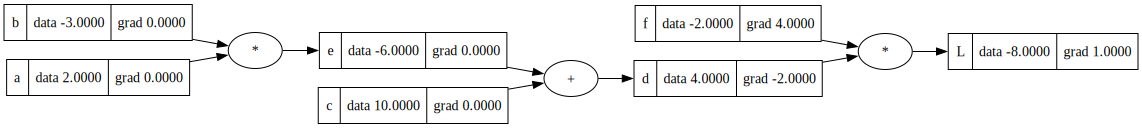

In [27]:
draw_dot(L)


In [28]:
# dL/df = ? [we expect 4 which is d.data]

def verify_derivatives_numerically(): #done so that I don't mess up the global scope
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'

    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'

    f = Value(-2.0 + h, label='f')
    L = d * f; L.label = 'L'

    L2 = L.data

    print((L2-L1)/h)

verify_derivatives_numerically()


3.9999999999995595


So, dL/df = 4 (which is the value of d)


In [29]:
# dL/dd = ? [we expect -2 which is f.data]

def verify_derivatives_numerically(): #done so that I don't mess up the global scope
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

verify_derivatives_numerically()


-2.000000000000668


So we added a little h to d and see how L changes, to get $dL/dd = -2$


IMP

We now want to derive the gradient of L with respect to c


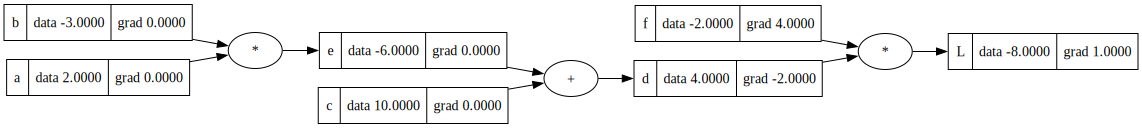

In [30]:
draw_dot(L)


We want $\frac{dL}{dc}$ now.

Let's calculate $\frac{dd}{dc}$


If you know the impact that `c` is having on `d` and the impact d is having on `L` then, we should be able to figure out how `c` impacts `L`.


Given,

We know, $d = c + e$

`dd/dc` ? --> `1.0`

Back to basics:

dd/dc = ?

d = c + e

(f(x+h) - f(x))/h

((c+h + e) - (c + e))/h

(h/h) -> 1 


So by symmetry dd/de = 1


So the local derivative is 1. The local plus node does not know anything about the rest of the graph...

The local graph knows dd/de and dd/dc...


So we know how `d` impacts `L` and how `c` & `e` impact `d`.

Chain rule intuition:

If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man.


So we want

WANT:

$\frac{dL}{dc} = \frac{dL}{dd} \cdot \frac{dd}{dc}$


KNOW:
- dL/dd
- dd/dc


But the derivative of dd/dc is 1 as it's a plus node, so it just routes the gradient $\frac{dL}{dd}$ to both $c$ and $e$ nodes.

In [31]:
c.grad = -2.0 * 1
e.grad = -2.0 * 1


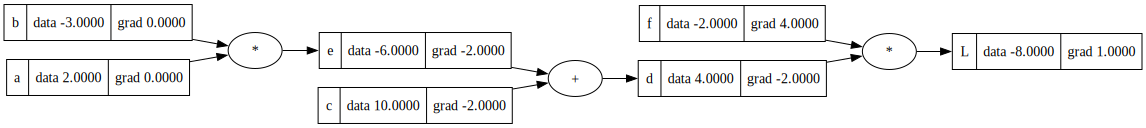

In [32]:
draw_dot(L)


In [33]:
# Verify dL/dc

def verify_derivatives_numerically(): #done so that I don't mess up the global scope
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0+h, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

verify_derivatives_numerically()


-1.9999999999988916


In [34]:
# Verify dL/de

def verify_derivatives_numerically(): #done so that I don't mess up the global scope
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    e.data += h
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

verify_derivatives_numerically()


-2.000000000000668


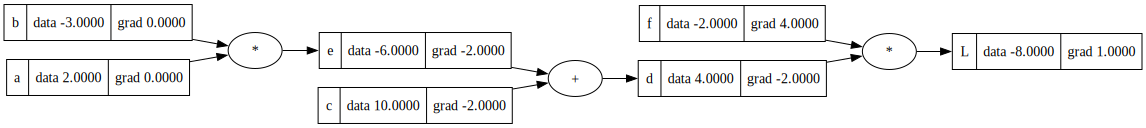

In [35]:
draw_dot(L)


So, we know $\frac{dL}{de} = -2$;


We want $\frac{dL}{da} = \frac{dL}{de} \cdot \text{local gradient}$

-> $\frac{dL}{da} = \frac{dL}{de} \cdot \frac{de}{da}$ 

---

Or, another way to do it 

$\frac{dL}{da} = \frac{de}{da} \cdot \frac{dd}{de} \cdot \frac{dL}{dd}$ 


or 

e = a*b

de/da ? -> b


dL/da = (dL/de) * (de/da)


In [36]:
# So

# dL/de = -2

a.grad = -2.0 * -3.0          # (-3 = b.data)
b.grad = -2.0 * 2.0         # (2 = a.data)


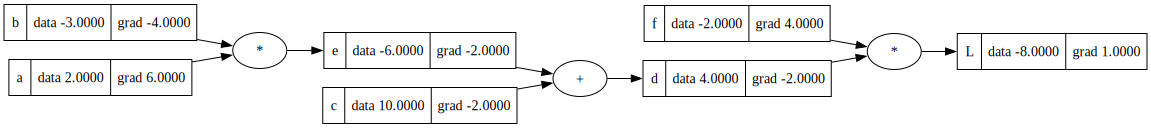

In [37]:
draw_dot(L)


In [38]:
# Verify dL/da

def verify_derivatives_numerically(): #done so that I don't mess up the global scope
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0+h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

verify_derivatives_numerically()


6.000000000000227


In [39]:
# Verify dL/db
def verify_derivatives_numerically(): #done so that I don't mess up the global scope
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0+h, label='b')
    c = Value(10.0, label='c')   
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    # print(round((L2-L1)/h, 3))
    print((L2-L1)/h)

verify_derivatives_numerically()


-3.9999999999995595


So now let's try to increase the value of `L` based on our knowledge of the gradient.


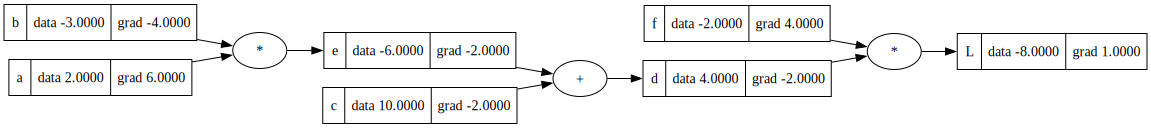

In [40]:
draw_dot(L)


We are going to nudge our inputs to make L go up. To make L go up we have to nudge our inputs in the direction of the gradient.


In [41]:
# Leaf nodes which we usually have control over.

# If we nudge in the direction of the gradient, we expect a positive
# influence on L. 

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# this is the forward pass:
e = a*b
d = e + c
L = d * f

print(L.data)


-7.286496


Because we nudged all the inputs in the direction of the gradient, we expect a less negative L.


## LET US NOW BACKPROP THROUGH A NEURON

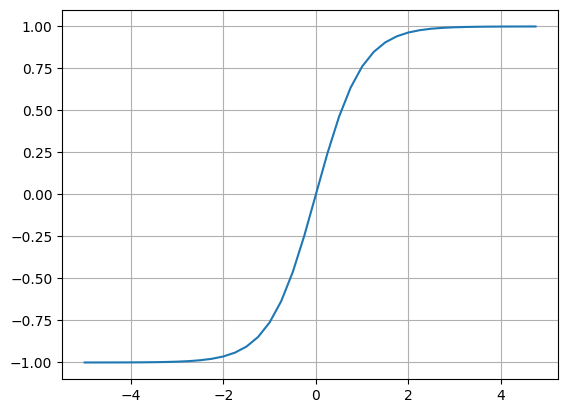

In [42]:
plt.plot(np.arange(-5,5,0.25), np.tanh(np.arange(-5,5,0.25))); plt.grid();


`tanh` is basically the squashing function. Whatever output comes it will squash between `-1` and `1` and if the output is highly positive then it will cap it smoothy at 1.


<img src="./image.png" width="40%">


The bias is the innate trigger happiness of the neuron. The activation is generally a squashing function.


In [43]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron (w1,w2) -> they are the synaptic strengths for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#   bias of the neuron
b = Value(6.7, label='b')

# So all we're trying to do is `x1*w1 + x2*w2 + b`

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'    
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'


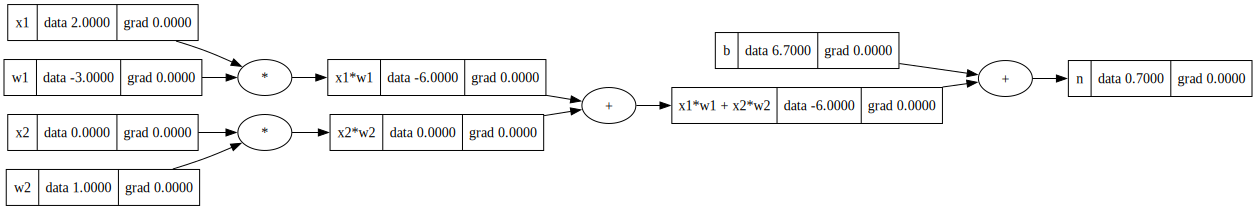

In [44]:
draw_dot(n)


So now we've taken the dot product of the weights and the neurons, and we need to pass it through an activation function. So let's pass it through `tanh`. But we have to first create this function in our Value object.

So we can implement functions at any level of abstraction in the `Value` Class. The only thing that matters when we implement a function in the Value Class is that we should know how to differentiate through it so that we can backpropagate through it. We need to know the local derivative.

In [45]:
# # inputs
# x1 = Value(2.0, label='x1')
# x2 = Value(0.0, label='x2')
# 
# #weights of the neuron (w1,w2) -> they are the synaptic strengths for each input
# w1 = Value(-3.0, label='w1')
# w2 = Value(1.0, label='w2')
# 
# #   bias of the neuron
# b = Value(6.7, label='b')
# 
# # So all we're trying to do is `x1*w1 + x2*w2 + b`
# 
# x1w1 = x1*w1; x1w1.label='x1*w1'
# x2w2 = x2*w2; x2w2.label='x2*w2'    
# x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# n = x1w1x2w2 + b; n.label = 'n'
# 
# # Let's call the output `o`
# 
# o = n.tanh(); o.label="output"


So now we need to implement tanh in our value class.

1. Use exp and then build it from there
2. Cluster up and implement tanh directly


The only thing that matters is that we know how to differentiate tanh
and understand how it is impacting the output when some input goes through
it.


In [46]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data,  (self, other), "*")
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out


$$ tanh = \frac{e^{2x} - 1}{e^{2x} + 1} $$

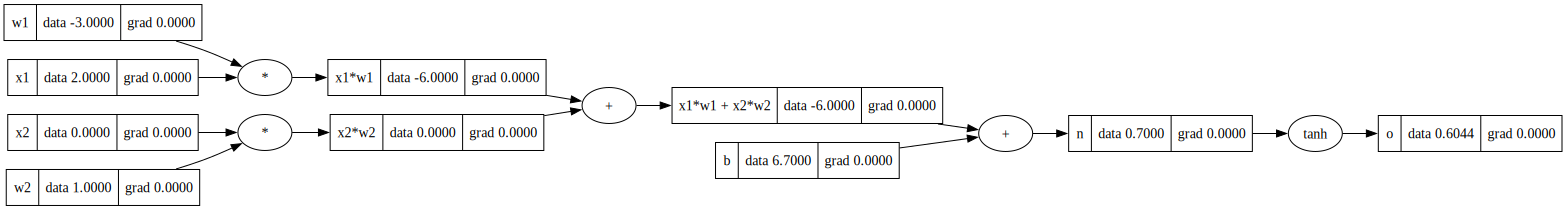

In [47]:
# So re-defining our Neuron:

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.7, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# Let's call the output `o`

o = n.tanh(); o.label="o"
draw_dot(o)


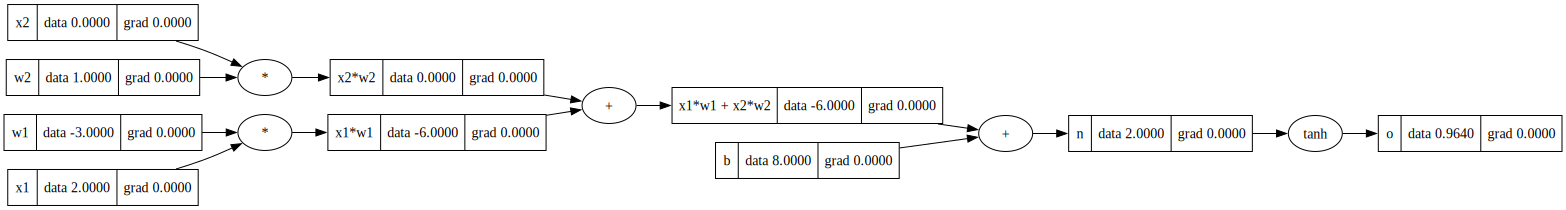

In [48]:
# To see the squashing nature of tanh active.

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(8, label='b') # changing the value of the Bias to increase the raw output of the neuron so that we can see the squashing nature of `tanh`


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"
draw_dot(o)


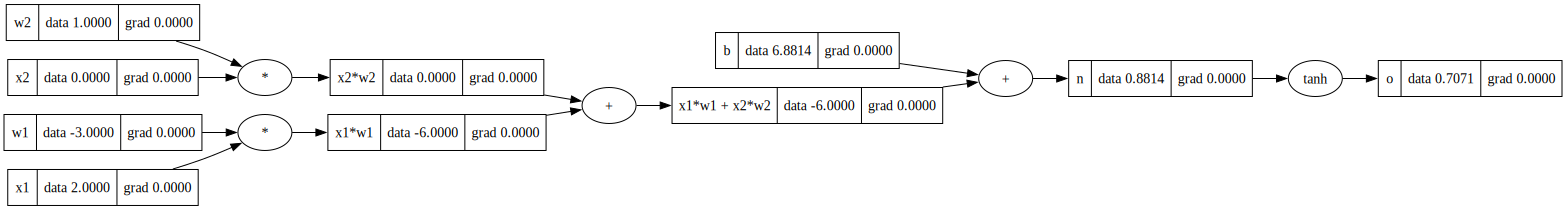

In [49]:
# To see the get good numbers during backprop, we set bias to be a crazy number...

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"
draw_dot(o)


Let's start off backprop!

Remember this is just one node. In a NN there are multiple nodes and then there's a loss function as well


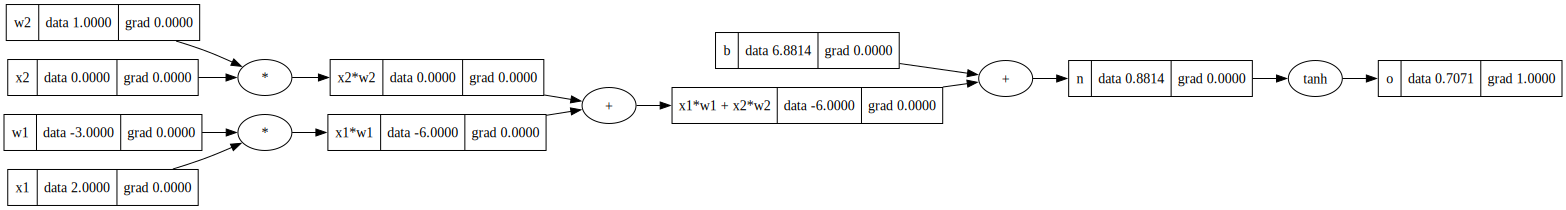

In [50]:
# what is the derivative of o with respect to o? i.e. what is do/do?

o.grad = 1.0
draw_dot(o)


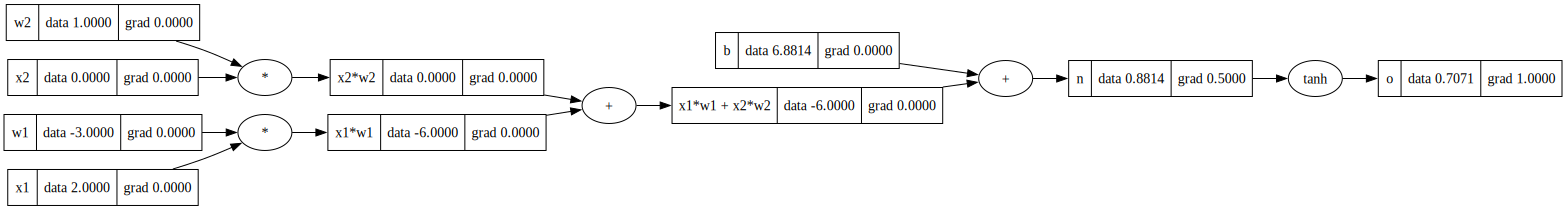

In [51]:
# We have, o = tanh(n)
# Then, what is do/dn ?

# do/dn = 1 - (tanh(n))**2
# do/dn = 1 - (o)**2

# so

n.grad = round(1 - (o.data)**2, 4) ## 0.5
draw_dot(o)


$n = b + (x1*w1+x2*w2)$

$
\frac{dn}{db} = 1
$

$
\frac{dn}{d(x_1 w_1 + x_2 w_2)} = 1
$

$
\text{So we want} \quad \frac{do}{db} = \frac{do}{dn} \cdot \frac{dn}{db} = 0.5 \cdot 1
$

$
\text{So we want} \quad \frac{do}{x1w1x2w2} = \frac{do}{dn} \cdot \frac{dn}{x1w1x2w2} = 0.5 \cdot 1
$


In [52]:
# So

x1w1x2w2.grad=0.5
b.grad = 0.5


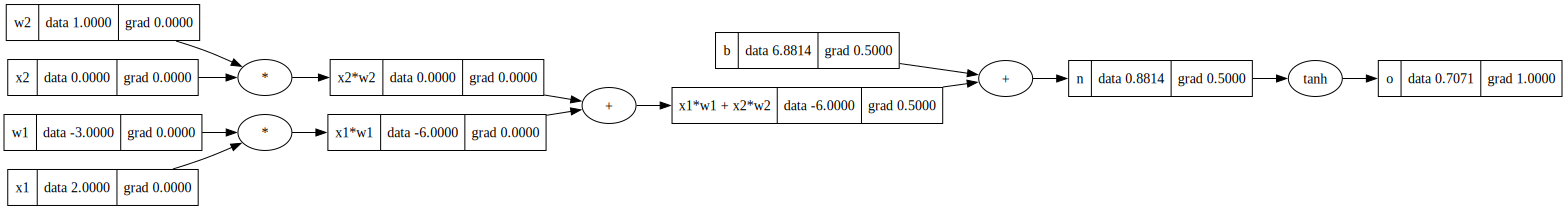

In [53]:
draw_dot(o)


$
\text{Again another plus, so we just distribute.}
$

$
\text{So we have,} \quad x_1 w_1 x_2 w_2 = x_1 w_1 + x_2 w_2
$

$
\text{And we want} \quad \frac{do}{d(x_1 w_1)} \quad \text{and} \quad \frac{do}{d(x_2 w_2)}
$

$
\frac{do}{d(x_1 w_1)} = \frac{d(x_1 w_1 x_2 w_2)}{d(x_1 w_1)} \cdot \frac{do}{d(x_1 w_1 x_2 w_2)} = 1 \cdot 0.5 = 0.5
$

In [54]:
# 

x1w1.grad=0.5
x2w2.grad = 0.5


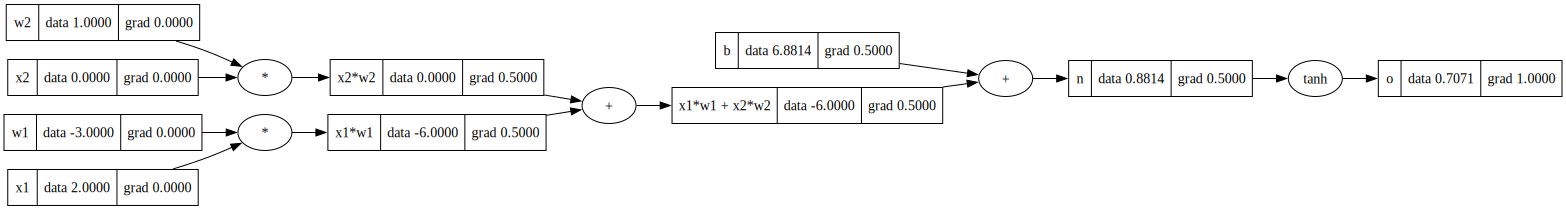

In [55]:
draw_dot(o)


Now let's calculate the grad for `x2` and `w2`.


### Check notes on iPad for it to make sense

<img src="./back-prop-understand.jpeg" width="30%">


$x_2 w_2 = x_2 \cdot w_2$

So,

$\frac{d(x_2 w_2)}{dx_2} = w_2$  
$\frac{d(x_2 w_2)}{dw_2} = x_2$

And

$\frac{do}{dx_2} = \frac{d(x_2 w_2)}{dx_2} \cdot \frac{do}{d(x_2 w_2)} = w_2 \cdot \frac{do}{d(x_2 w_2)} = w_2.\text{data} \cdot x_2 w_2.\text{grad} = 1 \cdot 0.5 = 0.5$

$\frac{do}{dw_2} = \frac{d(x_2 w_2)}{dw_2} \cdot \frac{do}{d(x_2 w_2)} = x_2 \cdot \frac{do}{d(x_2 w_2)} = x_2.\text{data} \cdot x_2 w_2.\text{grad} = 0 \cdot 0.5 = 0$

In [56]:
x2.grad = w2.data * x2w2.grad 
w2.grad = x2.data * x2w2.grad


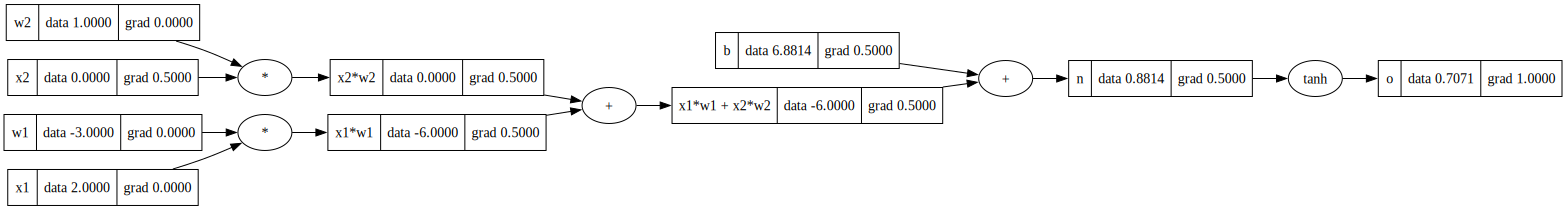

In [57]:
draw_dot(o)


w2's grad is 0 because of the way the multiplication operations works.


The derivative tells us the influence of the node on the final output. If I wiggle w2, the output does not change at all, so the derivative which tells us the effect that w2 has on the output also reports the same i.e. 0


In [58]:
x1.grad = w1.data * x1w1.grad # (x1*w1 = x1w1   dx1w1/dx1 = w1 and x1w1.grad = do/d(x1w1))
w1.grad = x1.data * x1w1.grad # (x1*w1 = x1w1   dx1w1/dw1 = x1 and x1w1.grad = do/d(x1w1))


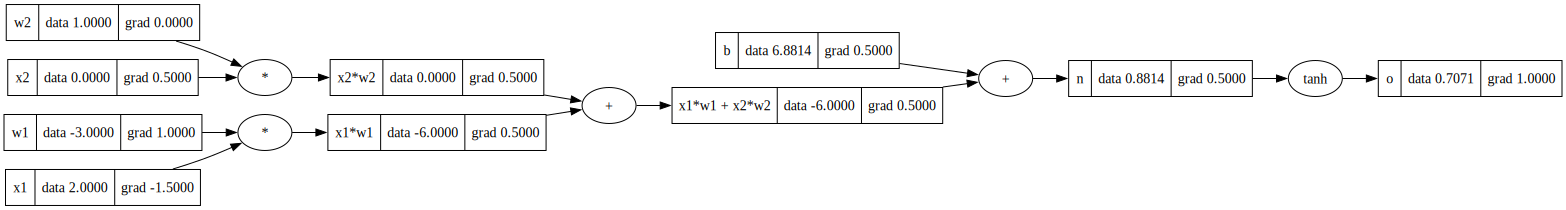

In [59]:
draw_dot(o)


#### So now let's codify the manual process we've been doing

In [60]:


class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient. It is a function.    

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad = 1.0 * out.grad 
            other.grad = 1.0 * out.grad
        
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out


Value class redefined.


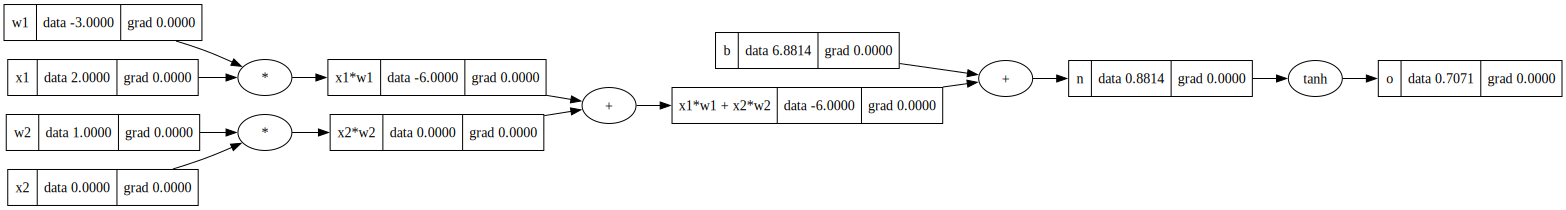

In [61]:
# Refine the expression post us re-defining the Value Node. To get good numbers during backprop.

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"

draw_dot(o)


In [62]:
o.grad = 1


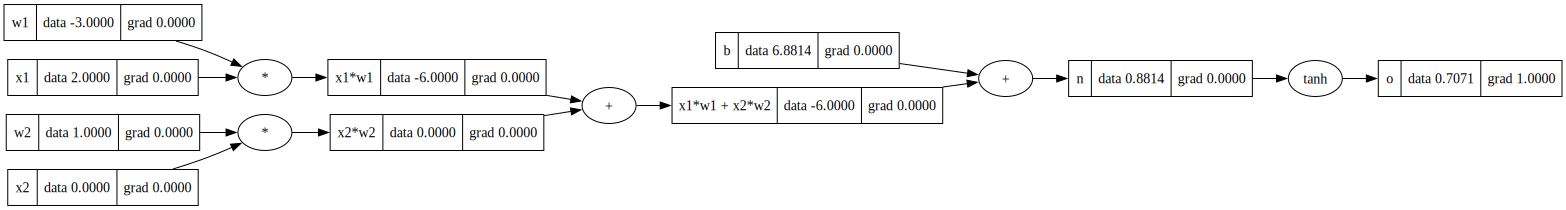

In [63]:
draw_dot(o)


In [64]:
o._backward()


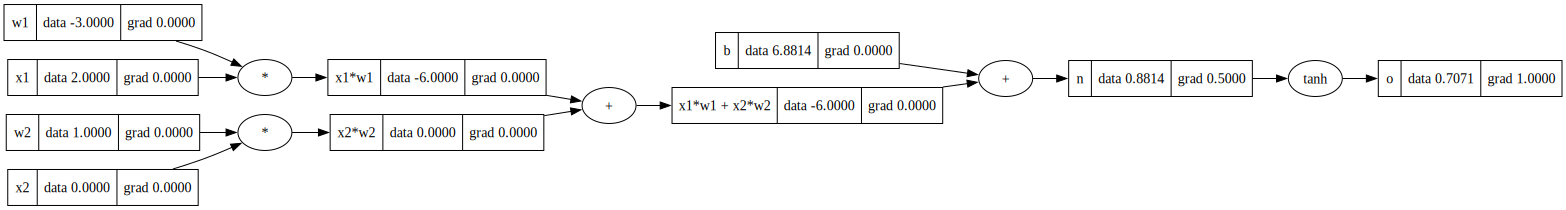

In [65]:
draw_dot(o)


In [66]:
n._backward()


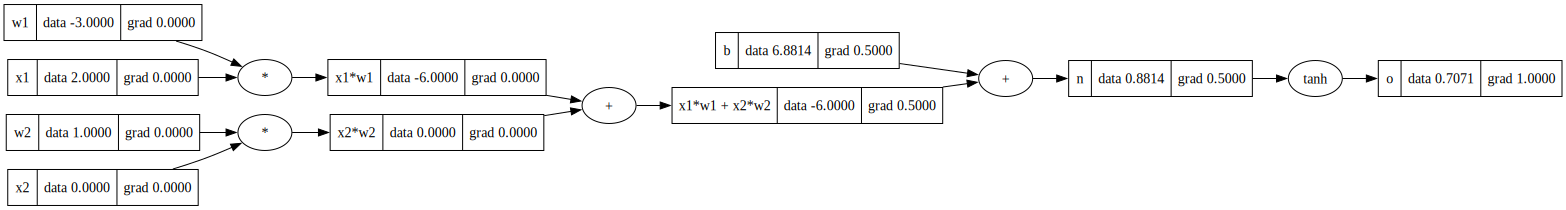

In [67]:
draw_dot(o)


#### lol b, does not even have a backward because it is a leaf node.


In [68]:
b._backward()


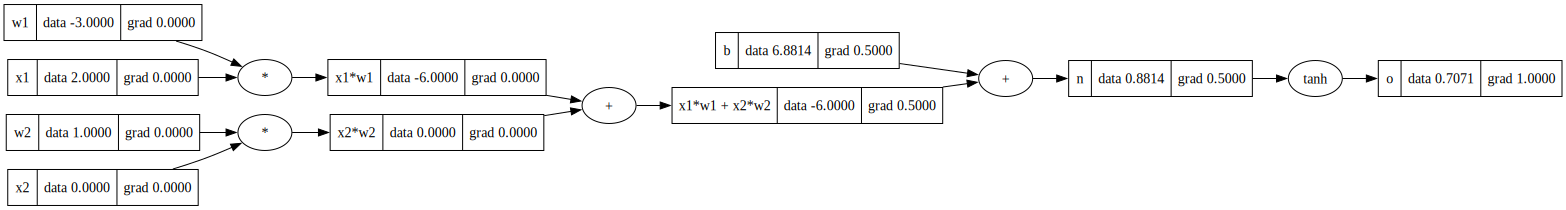

In [69]:
draw_dot(o)


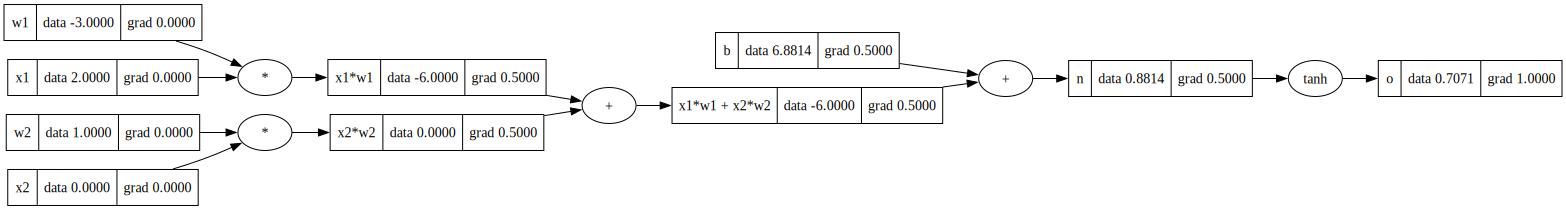

In [70]:
x1w1x2w2._backward()
draw_dot(o)


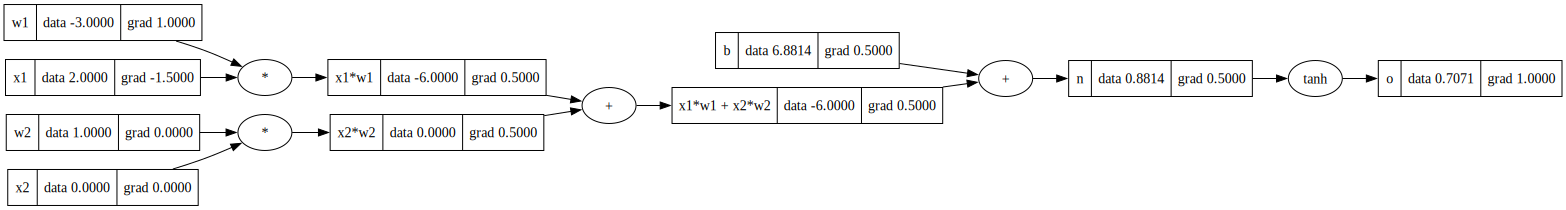

In [71]:
x1w1._backward()
draw_dot(o)



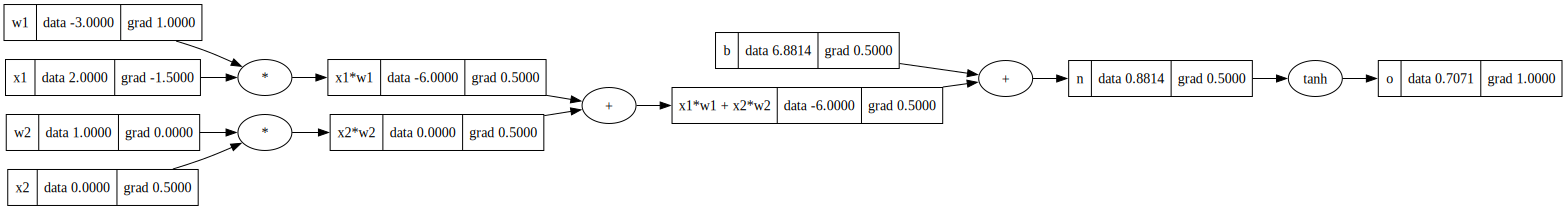

In [72]:
x2w2._backward()
draw_dot(o)


We need to now automate this and prevent us calling backward manually.


We never want to call a `._backward` for any node before we've done everything after it. We need to get everything of its dependencies before we can call `._backward`


To achieve this ordering of graphs, we can do topological sort.

In [73]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)

        for child in v._prev:
            build_topo(child)
        topo.append((v, v.label))


build_topo(o)
topo


[(Value(data=6.881373587019543), 'b'),
 (Value(data=-3.0), 'w1'),
 (Value(data=2.0), 'x1'),
 (Value(data=-6.0), 'x1*w1'),
 (Value(data=1.0), 'w2'),
 (Value(data=0.0), 'x2'),
 (Value(data=0.0), 'x2*w2'),
 (Value(data=-6.0), 'x1*w1 + x2*w2'),
 (Value(data=0.8813735870195432), 'n'),
 (Value(data=0.7071067811865476), 'o')]

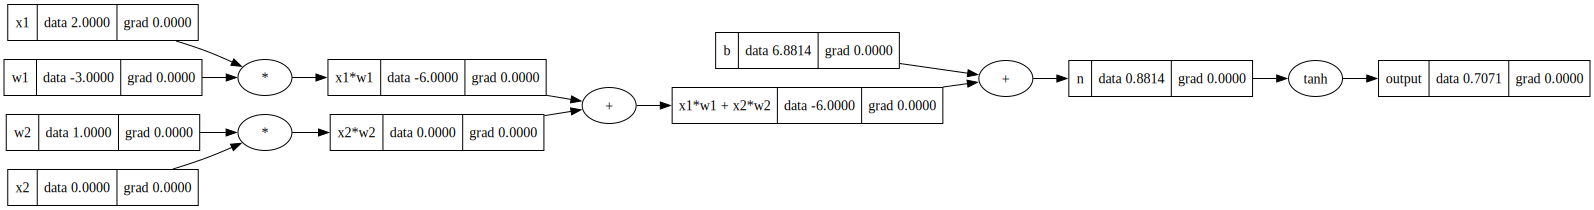

In [74]:
# So now, 

# let's reset the graph:

# To see the get good numbers during backprop.

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
output = n.tanh(); output.label = "output"

draw_dot(output)


In [75]:
output.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)

        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)


for node in reversed(topo):
    node._backward()


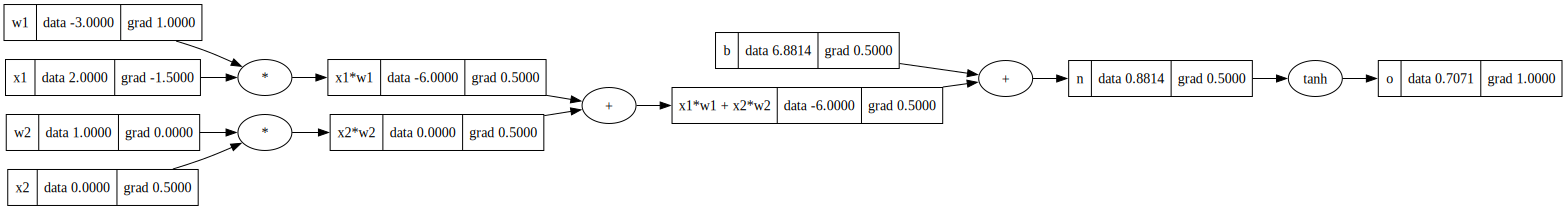

In [76]:
draw_dot(o)


So now let's hide this in the Value class


In [77]:
class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad = 1.0 * out.grad 
            other.grad = 1.0 * out.grad
        
        out._backward = backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):        
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


#### Redefine


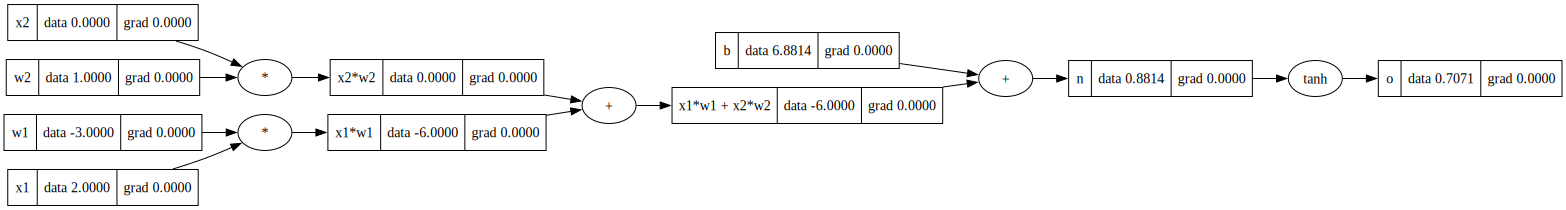

In [78]:
# To see the get good numbers during backprop.

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"

draw_dot(o)


In [79]:
o.backward()


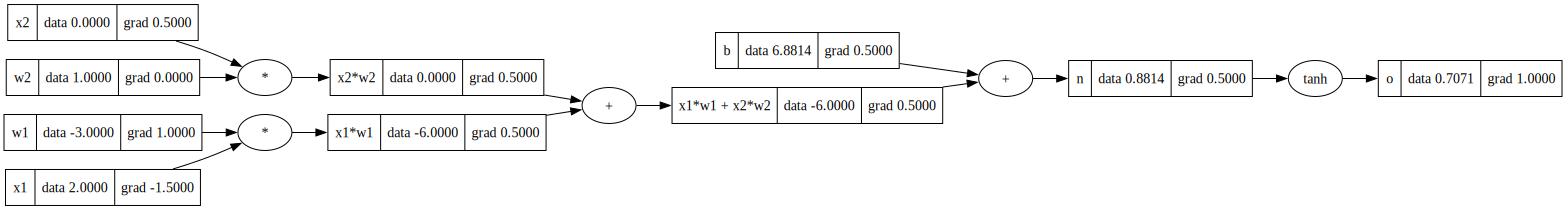

In [80]:
draw_dot(o)


## But wait, there is an error!

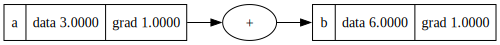

In [81]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)


This is wrong, because `b=2a` and $\frac{db}{da}$ = `2` but `1` is reflected.

This is happening because the gradient is being overwritten.

```
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad = 1.0 * out.grad 
            other.grad = 1.0 * out.grad
        
        out._backward = backward
        
        return out
```

So here `out` is `b`; And when we do `b._backward()` basically what's happening is `a.grad=1` and `a.grad=1`; `1` is being assigned to `a.grad` twice or it's being overwritten as both `self` and `other` represent the same `Value` object of `a`.


Another way to see the same problem:

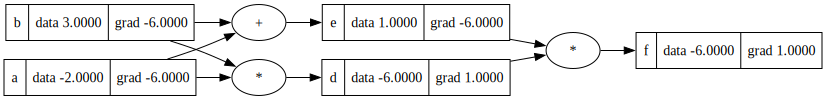

In [82]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)


Problem is that when the same variable is being used twice, the gradient value is being overwritten.

So first `a` and `b`'s gradient is being calculated as `-6.0` according to the `e` node that "distributes".

Then `e` calls a backward and it deposits its gradients to `a` and `b` but when `d` calls it's backward, it overwrites the gradients at `a` and `b`.

THe solution is to just accumulate the gradients...


In [83]:
# So, the only way to deal with this is to look at the multivariate case 

# So, just add `+=` to the gradient things as the gradients accumulate.

class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):        
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


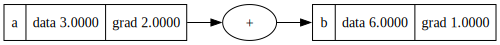

In [84]:
# Redefine:

a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)


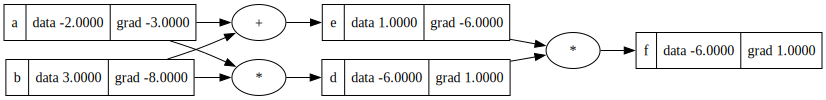

In [85]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)


e.backward  --> `a.grad` = `-6` and `b.grad` = `-6`; then when we call d.backward, we accumulate the grdients i.e.


- `a.grad` = -6 + (3 * `d.grad`) = -6 + 3*1 = -3

- `b.grad` = -6 + (-2 * `d.grad`) = -6 + -2*1 = -8


## So this works perfectly now. The gradients just accumulate on top of each-other.


# Making it more realistic and better

In [86]:
# So,

a = Value(2.0)
a + 1


AttributeError: 'int' object has no attribute 'data'

This fails because 1 is an integer so `other` is 1 and `1.data` does not mean anything.


In [87]:
# So, the only way to deal with this is to look at the multivariate case 

# So, just add `+=` to the gradient things as the gradients accumulate.

class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


In [88]:
# So,

a = Value(2.0)
a + 1


Value(data=3.0)

In [89]:
a = Value(2.0)
a * 8


Value(data=16.0)

In [90]:
# But, 8 * a will not work

8 * a


TypeError: unsupported operand type(s) for *: 'int' and 'Value'

So we need to define `rmul`

Under the hood,

`a * 8 --> a.__mul__(8)`

and 

`8 * a --> 8.__mul__(a)`

But that will obviously fail


In [91]:
class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out


    def __rmul__ (self, other): # other * self # fallback; it will check is a knows now to multiply 2...
        return self * other # 2*a --> rmul --> a*2 will be called
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


In [92]:
# But, 8 * a will not work
a = Value(2.0)
8 * a


Value(data=16.0)

In [93]:
# So, the only way to deal with this is to look at the multivariate case 

# So, just add `+=` to the gradient things as the gradients accumulate.

class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out


    def __rmul__ (self, other): # other * self
        return self * other
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.

            # d(e^x)/dx = e^x = out.data
        
        out._backward = _backward
    
        return out
    

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


In [94]:
a = Value(2.0)
a.exp()


Value(data=7.38905609893065)

In [95]:
# Now let's do division
a = Value(2.0)
b = Value(4.0)

a/b



TypeError: unsupported operand type(s) for /: 'Value' and 'Value'

Division can be reshuffled as follows:

`a/b` = `a * 1/b` = `a * b**(-1)`

In [96]:
# So let's implement x**k for some constant k; Then division will be a special case with k=-1


In [97]:
# So, the only way to deal with this is to look at the multivariate case 

# So, just add `+=` to the gradient things as the gradients accumulate.

class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    

    def __pow__(self, other):

        # => self**(other)

        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward

        return out


    def __rmul__ (self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**(-1)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        
        out._backward = _backward
    
        return out
    

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


In [98]:
# Now let's do division

a = Value(2.0)
b = Value(4.0)

a/b



Value(data=0.5)

In [99]:
# Now let's do division

a = Value(2.0)
b = Value(4.0)

a - b



TypeError: unsupported operand type(s) for -: 'Value' and 'Value'

In [100]:
class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = backward
        
        return out
    

    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward

        return out


    def __rmul__ (self, other): # other * self
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out


    

    def __truediv__(self, other): # self / other
        return self * other**(-1)
    
    def __radd__(self, other):  # other + self
        return self + other
    
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        
        out._backward = _backward
    
        return out
    

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


In [101]:
# Now let's do division

a = Value(2.0)
b = Value(4.0)

a - b



Value(data=-2.0)

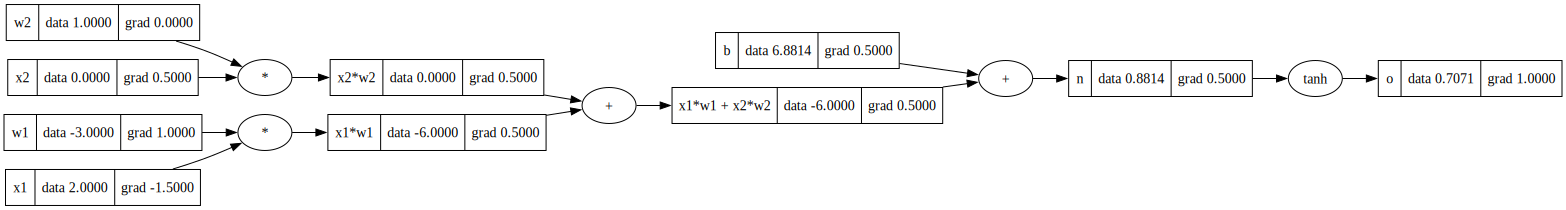

In [102]:
# To see the get good numbers during backprop.

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"
o.backward()
draw_dot(o)


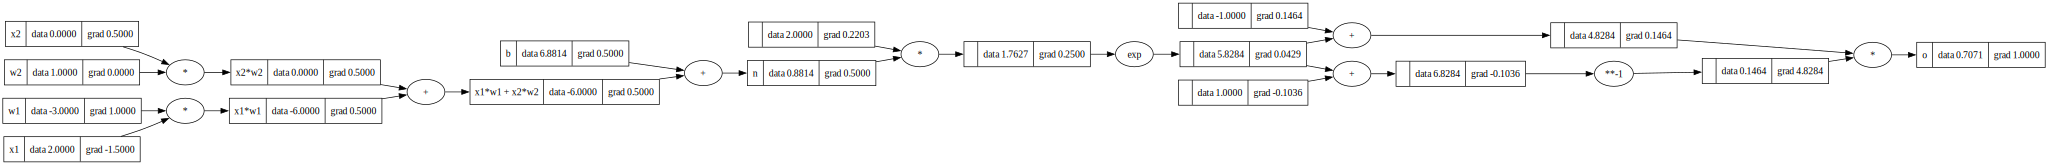

In [103]:
# To see the get good numbers during backprop.

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')


x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# -----
# output = n.tanh(); output.label = "output" # old way to do it; we will break it up now


e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

# -------


o.backward()
draw_dot(o)


In [104]:
import torch


In [105]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print("o:", o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


o: 0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


#### So our micrograd is really similar to the PyTorch API except for the fact that in PyTorch everything happens in arrays of numbers not single scaler values (like in our case), so it's much more efficient.


So we've sort of modelled PyTorch on a backprop side, we're now going to try and model PyTorch from an API side that faces the client


# Let's now model a neural network

In [106]:
# class Value:

#     def __init__(self, data, _children=(), _op="", label=""):
#         self.data = data
#         self.grad = 0.0
#         self._backward = lambda: None
#         self._prev = set(_children)
#         self._op = _op
#         self.label = label

#     def __repr__(self):
#         return f"Value(data={self.data})"

#     def __add__(self, other):
#         other = other if isinstance(other, Value) else Value(other)
#         out = Value(self.data + other.data, (self, other), "+")

#         def _backward():
#             self.grad += 1.0 * out.grad
#             other.grad += 1.0 * out.grad

#         out._backward = _backward

#         return out

#     def __mul__(self, other):
#         other = other if isinstance(other, Value) else Value(other)
#         out = Value(self.data * other.data, (self, other), "*")

#         def _backward():
#             self.grad += other.data * out.grad
#             other.grad += self.data * out.grad

#         out._backward = _backward

#         return out

#     def __pow__(self, other):
#         assert isinstance(
#             other, (int, float)
#         ), "only supporting int/float powers for now"
#         out = Value(self.data**other, (self,), f"**{other}")

#         def _backward():
#             self.grad += other * (self.data ** (other - 1)) * out.grad

#         out._backward = _backward

#         return out

#     def __rmul__(self, other):  # other * self
#         return self * other

#     def __truediv__(self, other):  # self / other
#         return self * other**-1

#     def __neg__(self):  # -self
#         return self * -1

#     def __sub__(self, other):  # self - other
#         return self + (-other)

#     def __radd__(self, other):  # other + self
#         return self + other

#     def tanh(self):
#         x = self.data
#         t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
#         out = Value(t, (self,), "tanh")

#         def _backward():
#             self.grad += (1 - t**2) * out.grad

#         out._backward = _backward

#         return out

#     def exp(self):
#         x = self.data
#         out = Value(math.exp(x), (self,), "exp")

#         def _backward():
#             self.grad += (
#                 out.data * out.grad
#             )  # NOTE: in the video I incorrectly used = instead of +=. Fixed here.

#         out._backward = _backward

#         return out

#     def backward(self):

#         topo = []
#         visited = set()

#         def build_topo(v):
#             if v not in visited:
#                 visited.add(v)
#                 for child in v._prev:
#                     build_topo(child)
#                 topo.append(v)

#         build_topo(self)

#         self.grad = 1.0
#         for node in reversed(topo):
#             node._backward()


In [107]:
import random


In [108]:
class Neuron:

    def __init__(self, nin): # nin how many inputs come to the neuron.

        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1)) # controls the overall trigger happiness

    def __call__(self, x):
        # w*x [dot product] + b 
        
        return 0.0


x = [2.0, 3.0]
n = Neuron(2)
n(x)  # --> this () notation initiates the `__call__` function


0.0

In [109]:
#  to illustrate how zip works
class Neuron:

    def __init__(self, nin):

        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w*x [dot product] + b 
        
        # zip takes two iterators and creates a new iterator that iterates over the tuple of the corresponding entries
        print(list(zip(self.w, x)))


        return 0.0

x = [2.0, 3.0]
n = Neuron(2)
n(x) 


[(Value(data=-0.43868571927512656), 2.0), (Value(data=0.55938313162409), 3.0)]


0.0

In [110]:
class Neuron:

    def __init__(self, nin):

        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w*x [dot product] + b

        act = sum(
            (wi * xi for wi, xi in zip(self.w, x)), self.b
        )  # start takes an optional parameter self.b ...

        # sum takes a start and then whatever sum computes will be added on top of start. By default start is 0, but we can set it to self.b to be a bit more efficient.

        out = act.tanh()

        return out


x = [2.0, 3.0]
n = Neuron(2)
n(x)



Value(data=-0.995839021457207)

In [111]:
class Neuron:

    def __init__(self, nin):

        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w*x [dot product] + b

        act = sum(
            (wi * xi for wi, xi in zip(self.w, x)), self.b
        )  # start takes an optional parameter self.b ...
        out = act.tanh()

        return out


class Layer:

    def __init__(self, nin, nout): # nout = number of outputs in this layer; or the number of neurons in this layer...
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


x = [2.0, 3.0]
n = Layer(2,3) # 3 two-dimensional neurons...
n(x)



[Value(data=0.9560120160242779),
 Value(data=0.964106417742881),
 Value(data=0.2554833658303933)]

Let's reimplement this

<img src="./neural_net2.jpeg" width="40%">


In [112]:
class Neuron:

    def __init__(self, nin):

        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w*x [dot product] + b

        act = sum(
            (wi * xi for wi, xi in zip(self.w, x)), self.b
        )  # start takes an optional parameter self.b ...
        out = act.tanh()

        return out


class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

    def __init__(self, nin, nouts): # nouts is a list; it will define the size of all the layers we want in our MLP
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4 , 1])
n(x)


Value(data=-0.943776995231023)

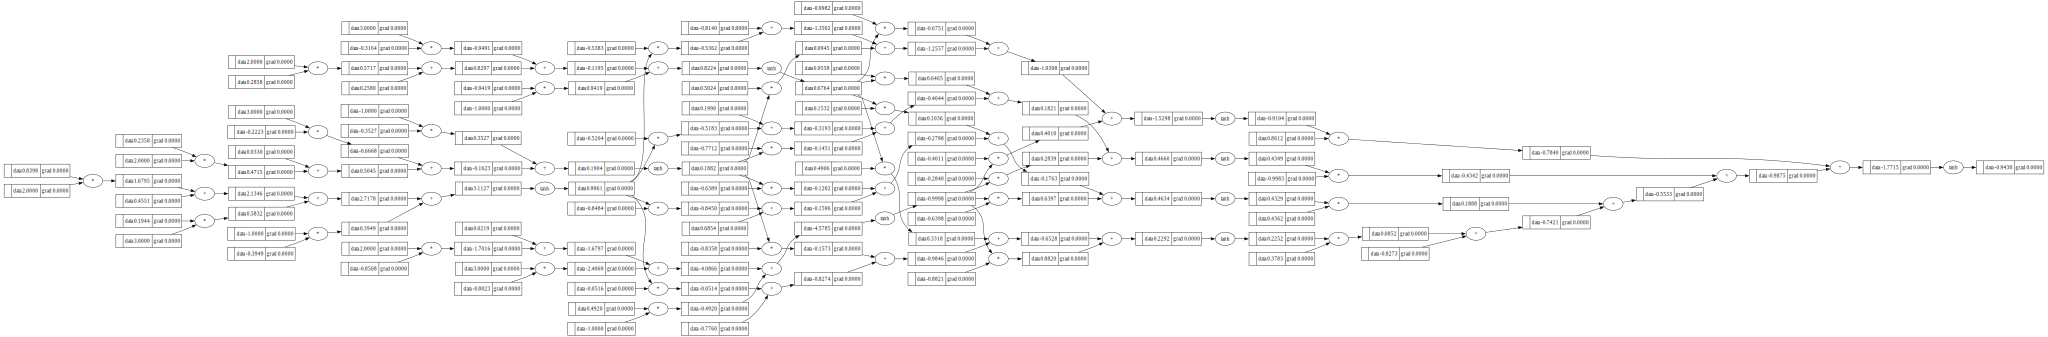

In [113]:
draw_dot(n(x))


In [114]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# 4 examples and 4 possible outputs...

ypred = [n(x) for x in xs]
ypred


[Value(data=-0.943776995231023),
 Value(data=-0.942833917179823),
 Value(data=-0.6029069536974089),
 Value(data=-0.9520886590919041)]

In [115]:
# How do we tune the weights to get the network to better predict the desired targets...
# We calculate a single number to measure the total performance of the Neural Net.


In [116]:
# [(yout - ygt)**2;  for ygt, yout in zip(ys, ypred)]
for ygt, yout in zip(ys, ypred):
    print(f"yout: {yout}, gt: {ygt}")
    print((yout - ygt)**2)


yout: Value(data=-0.943776995231023), gt: 1.0
Value(data=3.778269007189345)
yout: Value(data=-0.942833917179823), gt: -1.0
Value(data=0.0032679610250033347)
yout: Value(data=-0.6029069536974089), gt: -1.0
Value(data=0.15768288742187178)
yout: Value(data=-0.9520886590919041), gt: 1.0
Value(data=3.8106501329552276)


In [117]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data=7.749869988591447)

In [118]:
loss.backward()


Something magical happned when we called loss.backward().


In [119]:
n.layers[0].neurons[0].w


[Value(data=0.8397678858231854),
 Value(data=0.19438845038232522),
 Value(data=-0.39490542709198495)]

In [120]:
[n.layers[0].neurons[0].w[i].grad for i in range (len(n.layers[0].neurons[0].w))]


[-0.02764299673381198, -0.055114927732620674, -0.05451248295825067]

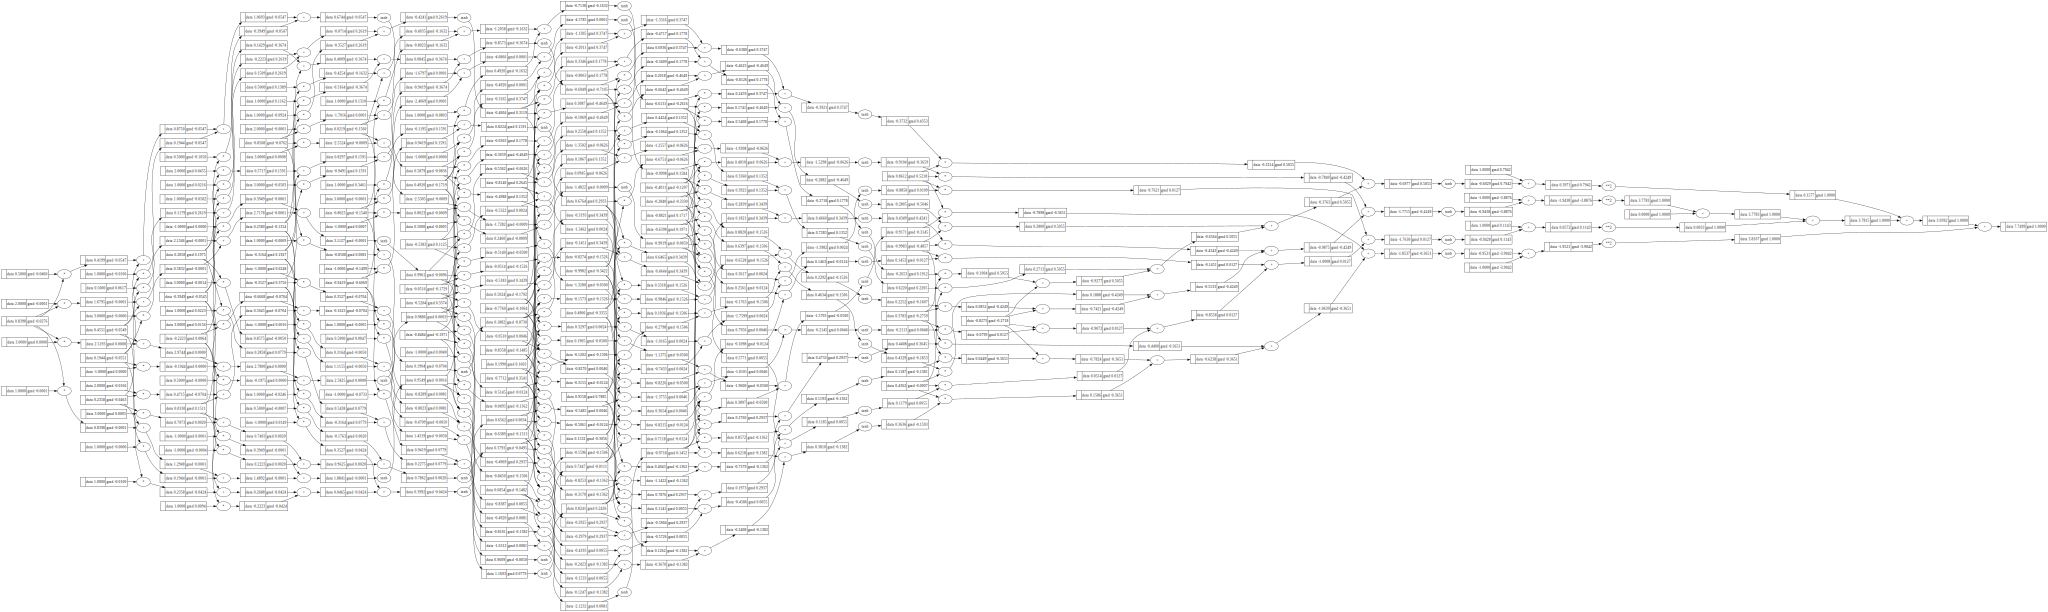

In [121]:
draw_dot(loss)


So now we want some convenience code so that we can gather up all the parameters conveniently and nudge all of them by a tiny amount...


In [122]:
class Neuron:

    def __init__(self, nin):

        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w*x [dot product] + b

        act = sum(
            (wi * xi for wi, xi in zip(self.w, x)), self.b
        )  # start takes an optional parameter self.b ...
        out = act.tanh()

        return out
    
    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # 
        # return params

        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [123]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4 , 1])
n(x)


Value(data=-0.9152129043425158)

In [124]:
n.parameters()


[Value(data=-0.6930380237530609),
 Value(data=-0.17416336821879685),
 Value(data=0.9383066396751352),
 Value(data=0.836720220290001),
 Value(data=-0.8058277189436103),
 Value(data=-0.10098940950465374),
 Value(data=-0.9581774637544507),
 Value(data=-0.8533510585824451),
 Value(data=0.6487069478000085),
 Value(data=0.16980574838009876),
 Value(data=-0.5493568683838761),
 Value(data=0.5582240820220248),
 Value(data=0.5996771286569225),
 Value(data=0.8316862767071229),
 Value(data=-0.9664962201469318),
 Value(data=0.35486125939851165),
 Value(data=0.3392994513519403),
 Value(data=0.7024786160192824),
 Value(data=-0.8059706672176756),
 Value(data=-0.9348685962903613),
 Value(data=-0.5905664966426387),
 Value(data=0.4328617928841798),
 Value(data=-0.9685931054056205),
 Value(data=0.2710992115081188),
 Value(data=-0.9742675169842083),
 Value(data=-0.5707954078057131),
 Value(data=0.6296633662467406),
 Value(data=0.9802367549542397),
 Value(data=-0.6541014465382007),
 Value(data=-0.2917981936

In [125]:
len(n.parameters())


41

In [126]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred


[Value(data=-0.9152129043425158),
 Value(data=-0.8267406134223618),
 Value(data=-0.4385872968549024),
 Value(data=-0.9258746690205119)]

In [127]:

# [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]


In [128]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data=7.722236748024907)

In [129]:
loss.backward()


In [130]:
# 0th layer of the MLP, 0th Neuron in the MLP, w[0]
# Since we said that a neuron has to take in 3 inputs we have 3 values printed for this
n.layers[0].neurons[0].w


[Value(data=-0.6930380237530609),
 Value(data=-0.17416336821879685),
 Value(data=0.9383066396751352)]

In [131]:
n.layers[0].neurons[0].w[0]


Value(data=-0.6930380237530609)

In [132]:
n.layers[0].neurons[0].w[0].grad


0.07913509663894222

In [133]:
# n.layers[0].neurons[0].w[0].data


Gradient can be thought of as a vector pointed in the direction of increased loss.

In [135]:
for p in n.parameters():
    p.data += -0.01 * p.grad


data = `-0.6930380` and grad = `0.079`; So if we increase the data then the loss will go up as we are doing it in the direction of the gradient. But we want to decrease the loss, so we need to decrease the data and that can be done with a negative sign


In [136]:
n.layers[0].neurons[0].w[0].data


-0.6938293747194503

Earlier loss: `7.72223`; Post update, we hopefully will get a lower loss.


In [137]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data=7.6718592886418175)

And it did! We got `7.6718`

In [138]:
# so now gradient descent manually:


## now loop this by running forward pass, backward pass, update manually in Jupyter Notebook


In [139]:
# data definition
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [164]:
# Forward pass

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data=9.90877553671626e-06)

In [165]:
# backward pass

loss.backward()


In [166]:
# nudge

for p in n.parameters():
    p.data += -0.1 * p.grad


In [167]:
ypred


[Value(data=0.9991537747144601),
 Value(data=-0.9979413642572316),
 Value(data=-0.9979412716296804),
 Value(data=0.9991536344296543)]

In [168]:
n.parameters()


[Value(data=2.1463636442507785),
 Value(data=-2.701155493964767),
 Value(data=2.4999462694328147),
 Value(data=1.317889357483656),
 Value(data=-1.383483624120784),
 Value(data=-0.7525419301826037),
 Value(data=-0.38498209909572867),
 Value(data=-1.3148310089177468),
 Value(data=-0.5044445801962434),
 Value(data=-0.03890635049264061),
 Value(data=-1.4467408624070353),
 Value(data=-0.31854563701913374),
 Value(data=1.827831964184488),
 Value(data=1.7200736052806664),
 Value(data=0.2901415639212334),
 Value(data=1.6956390033390212),
 Value(data=0.35912071951131286),
 Value(data=0.6737338536705361),
 Value(data=-0.7993374366033904),
 Value(data=-0.9013280328124592),
 Value(data=-0.5615840155107904),
 Value(data=-1.9761384170315046),
 Value(data=-0.39844072773284955),
 Value(data=0.8257212622972241),
 Value(data=-0.4380148595998183),
 Value(data=-0.8601141661961321),
 Value(data=0.3886811642205838),
 Value(data=1.2183103269541744),
 Value(data=-0.7348419580209413),
 Value(data=-0.4358054538

So let's make this a loop


In [169]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [170]:
# BUT THERE IS A BUG

for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    # loss

    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad

    
    print(f"step: {k},   loss.data: {loss.data}")


step: 0,   loss.data: 4.789046014468804e-07
step: 1,   loss.data: 1.0885968042456476e-07
step: 2,   loss.data: 2.553149306529077e-08
step: 3,   loss.data: 6.2124745470132265e-09
step: 4,   loss.data: 1.5676189153734779e-09
step: 5,   loss.data: 4.0733422735475044e-10
step: 6,   loss.data: 1.0789974385624538e-10
step: 7,   loss.data: 2.887562449901727e-11
step: 8,   loss.data: 7.759070831705473e-12
step: 9,   loss.data: 2.0859354036539872e-12
step: 10,   loss.data: 5.599197288670887e-13
step: 11,   loss.data: 1.498680672948196e-13
step: 12,   loss.data: 3.9956957993526134e-14
step: 13,   loss.data: 1.0602221163148657e-14
step: 14,   loss.data: 2.7980629954797416e-15
step: 15,   loss.data: 7.342831941467107e-16
step: 16,   loss.data: 1.9163346095625235e-16
step: 17,   loss.data: 4.976042491895045e-17
step: 18,   loss.data: 1.28650516669948e-17
step: 19,   loss.data: 3.314536569594468e-18


In [171]:
ypred


[Value(data=0.9999999987004816),
 Value(data=-0.9999999998387348),
 Value(data=-0.9999999998387411),
 Value(data=0.999999998745497)]

#### terrible bug; we didn't zero_grad


#### so you need to flush out the grad post every epoch, else it stays in there!


In [172]:
# reset the neural net

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4 , 1])
n(x)


Value(data=0.3510909498070853)

In [173]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [174]:

for k in range(30):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    # loss

    # basically zero_grad(); post every iteration to prevent the weights from stacking ontop of each-other, flush them out.
    for p in n.parameters():
        p.grad = 0.0
    
    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad

    
    print(k, loss.data)


0 4.335268471408987
1 3.219846465483267
2 2.5885215416934395
3 1.8823242538861784
4 0.943372544303547
5 0.444801721000634
6 0.27184658357637037
7 0.19193732110930628
8 0.14688298847292416
9 0.11824309790684565
10 0.0985447322253955
11 0.08422283726026221
12 0.07337210032596302
13 0.06488586067416273
14 0.05807914652429086
15 0.05250618735961145
16 0.04786486505647849
17 0.04394343863115688
18 0.04058926738524049
19 0.037689640410361054
20 0.03515958896152226
21 0.03293389090599689
22 0.03096168017903858
23 0.029202724443856416
24 0.02762479967925136
25 0.026201803169998362
26 0.02491237407740961
27 0.023738869550487287
28 0.022666594150837806
29 0.02168321256596143


In [175]:
ypred


[Value(data=0.9526764324936452),
 Value(data=-0.9237821478560829),
 Value(data=-0.9305460920868986),
 Value(data=0.9061347443693922)]

# So summary:

Neural nets are mathematical expressions that take input as the data and the weights/prams of the NN. 

Mathematical exporession for the forward pass followed by a loss function whcih tries to mesure the accuracy of the predictions
    
Loss is low when predictions match the targets. Network behaves well. 

We do backprop to get the gradient and know how to tune all the params to decrease the loss.

We iterate the process multiple times to decrease the loss. This is called gradient descent.


NNs can do really hard problems and have really fascinating emergent properties when you get it to do hard problems...

Now proving that what this notebooks contains is similar to https://github.com/karpathy/micrograd/tree/master


In [ ]:
class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # zero means no effect; we assume at initialisation that every value does not effect the output
        self._backward = lambda: None # at each node, we are going to store how we are going to chain the output's gradient into the inputs gradient

        self._prev = set(_children) # for efficiency
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            # self.grad = local derivitive * out's grad 
            # other.grad = local derivitive * out's grad

            # Since the local derivitive for addition is always 1,

            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = backward
        
        return out
    

    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,  (self, other), "*")


        def _backward():
            # self.grad = ???      local_derivitive * out's grad
            # other.grad = ???     local_derivitive * out's grad

            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward

        return out


    def __rmul__ (self, other): # other * self
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        
        out._backward = _backward

        return out


    

    def __truediv__(self, other): # self / other
        return self * other**(-1)
    
    def __radd__(self, other):  # other + self
        return self + other
    
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        
        out._backward = _backward
    
        return out
    

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


Forum post: https://discuss.pytorch.org/t/change-the-tanh-backward-code/148609/2

Line 96 (for GPU kernel) is where PyTorch defines it's backward pass for the tanh function: https://github.com/pytorch/pytorch/blob/a0a2b755659a0fd0e12d209ac84c402538a75e1b/aten/src/ATen/native/cuda/BinaryMiscBackwardOpsKernels.cu#L86-L100

Line 829 again: (for cpu kernel): 
https://github.com/pytorch/pytorch/blob/c5872e6d6d8fd9b8439b914c143d49488335f573/aten/src/ATen/native/cpu/BinaryOpsKernel.cpp#L793-L836


Here's how to register a new function in PyTorch for backprop: https://docs.pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
